Loading and processing parking data...

--- DATASET OVERVIEW ---
Time range: 2024-01-01 to 2024-12-31
Number of records: 76,128
Number of garage levels: 13
Total parking capacity: 5,264,544 spots


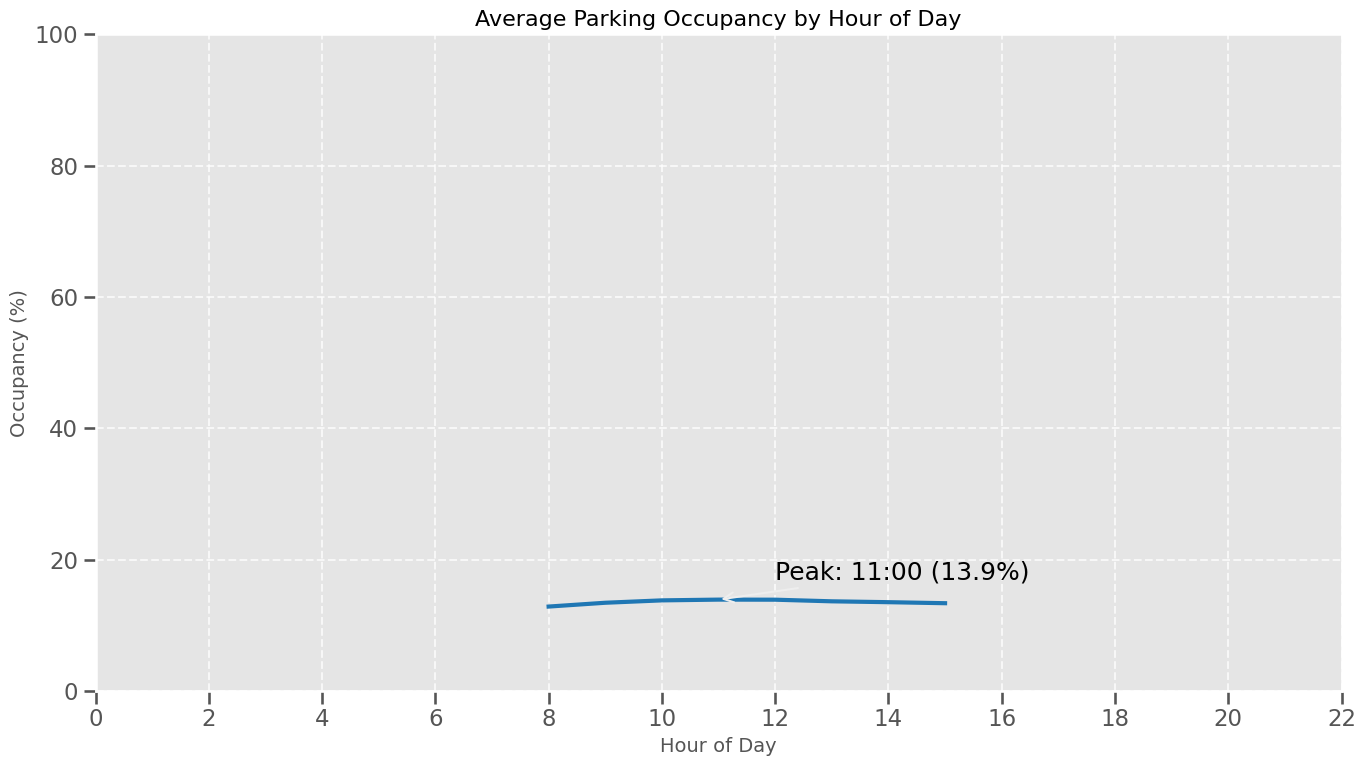

C:\Users\khurs\AppData\Local\Temp\ipykernel_11332\1222471161.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=day_data.index, y=day_data.values, palette='viridis')


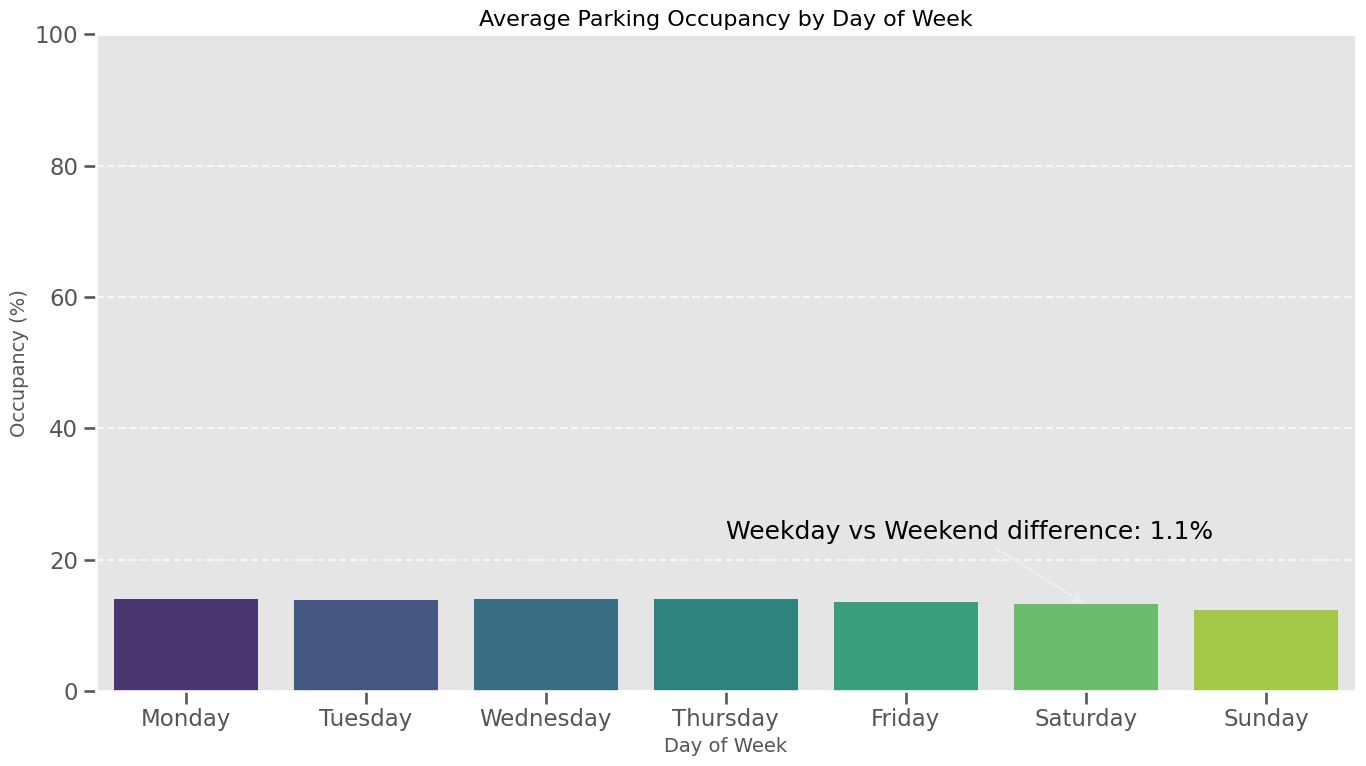

C:\Users\khurs\AppData\Local\Temp\ipykernel_11332\1222471161.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=levels, y=occupancy, palette='rocket')


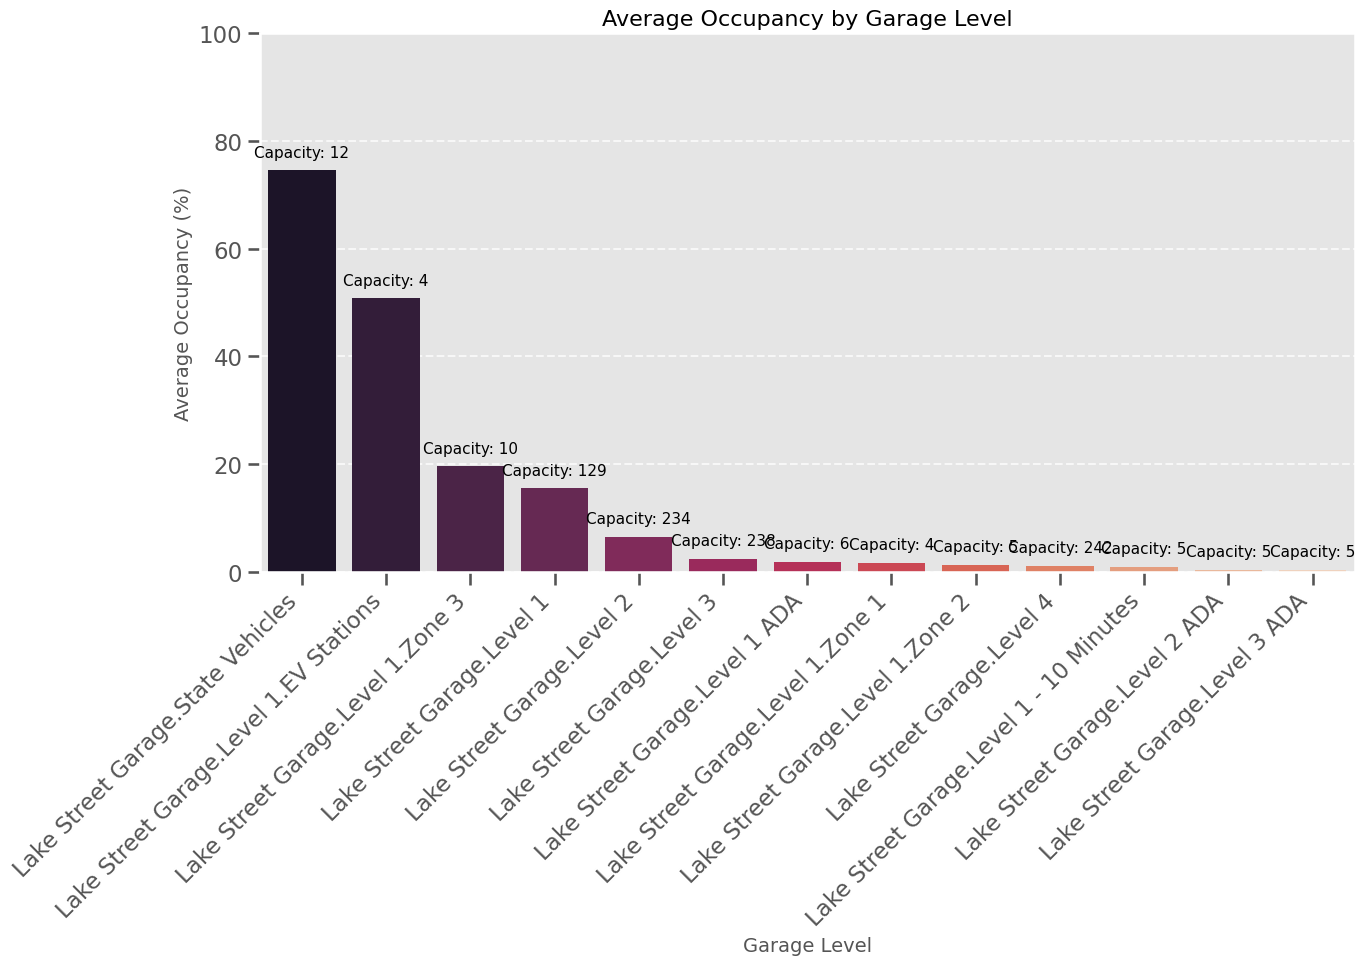

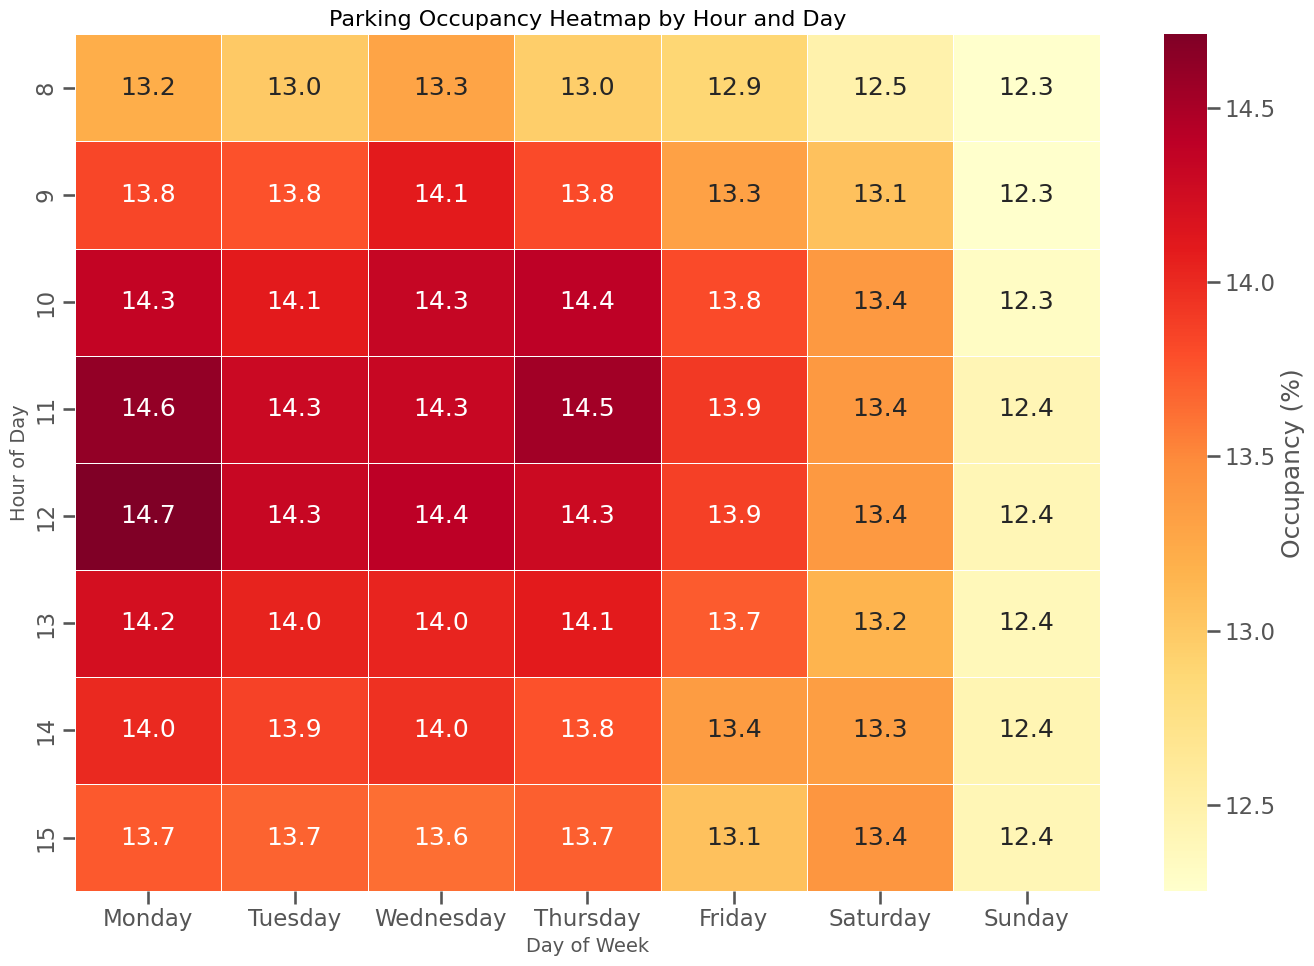

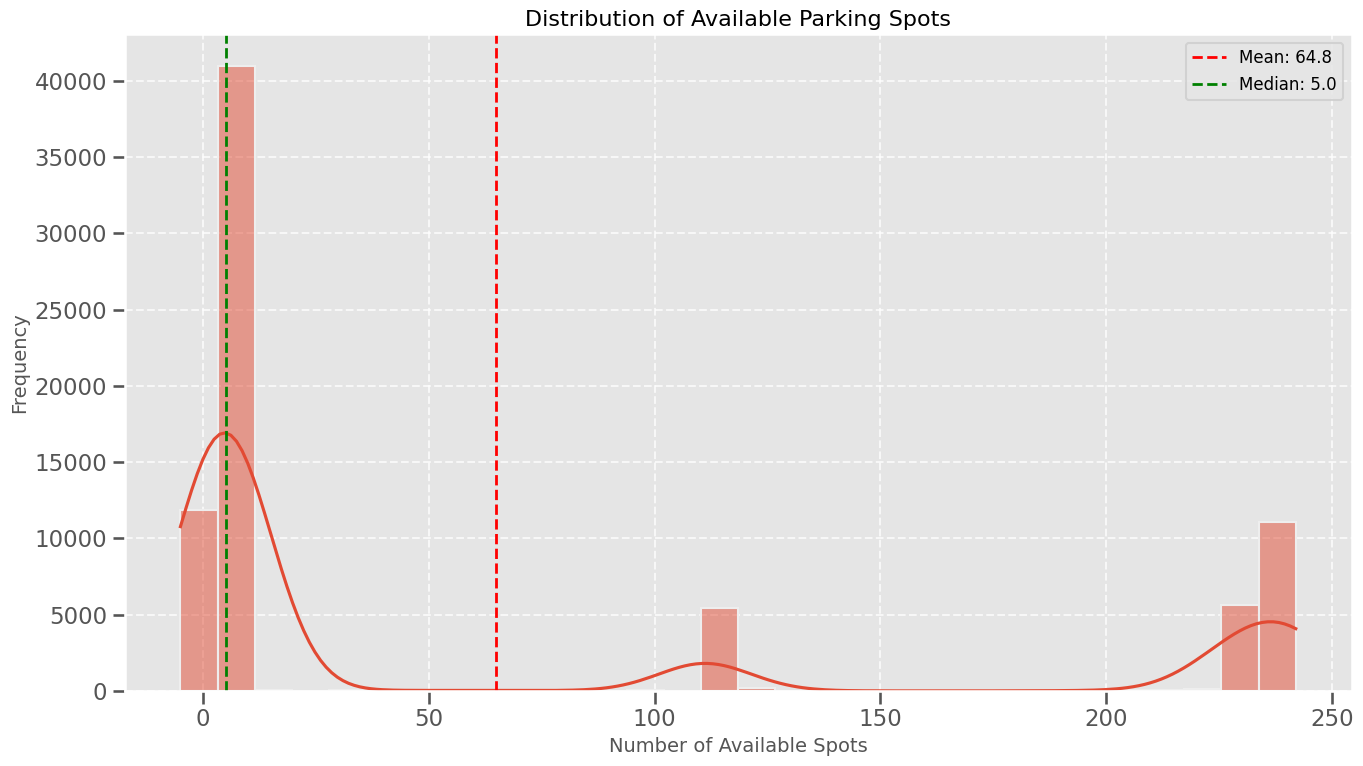

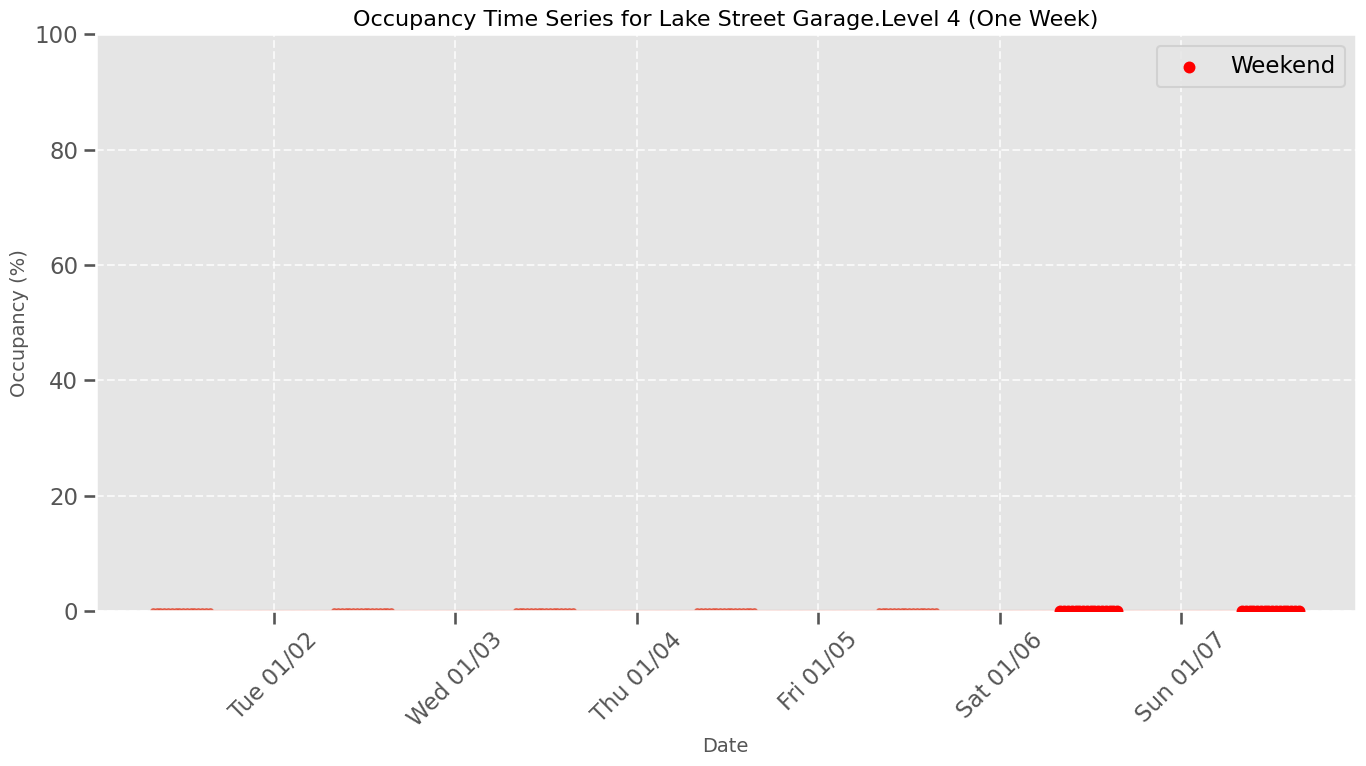


Visualization complete. These charts provide key insights into parking patterns.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates

# Set the style for our visualizations
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_context("talk")

def analyze_parking_data(csv_file='parking_data_2024 (1).csv'):
    """
    Analyze and visualize parking garage data
    """
    print("Loading and processing parking data...")
    
    # Load the data
    df = pd.read_csv(csv_file)
    df['Time'] = pd.to_datetime(df['Time'])
    
    # Extract time components
    df['Hour'] = df['Time'].dt.hour
    df['Day'] = df['Time'].dt.day
    df['Month'] = df['Time'].dt.month
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df['WeekDay'] = df['Time'].dt.day_name()
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Calculate available spots
    df['Available_Spots'] = (df['Free Avg %'] / 100) * df['Capacity']
    df['Available_Spots'] = df['Available_Spots'].round().astype(int)
    
    # Basic dataset information
    print("\n--- DATASET OVERVIEW ---")
    print(f"Time range: {df['Time'].min().date()} to {df['Time'].max().date()}")
    print(f"Number of records: {len(df):,}")
    print(f"Number of garage levels: {df['Level'].nunique()}")
    print(f"Total parking capacity: {df['Capacity'].sum():,} spots")
    
    # Create visualizations
    # 1. Occupancy by Hour of Day
    plt.figure(figsize=(14, 8))
    
    hourly_data = df.groupby('Hour')['Occ Avg %'].mean()
    ax = sns.lineplot(x=hourly_data.index, y=hourly_data.values, linewidth=3, color='#1f77b4')
    
    # Add peak hours annotation
    peak_hour = hourly_data.idxmax()
    plt.annotate(f'Peak: {peak_hour}:00 ({hourly_data.max():.1f}%)', 
                 xy=(peak_hour, hourly_data.max()), 
                 xytext=(peak_hour+1, hourly_data.max()+3),
                 arrowprops=dict(arrowstyle='->'))
    
    plt.title('Average Parking Occupancy by Hour of Day', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Occupancy (%)', fontsize=14)
    plt.xticks(range(0, 24, 2))
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. Day of Week Patterns
    plt.figure(figsize=(14, 8))
    
    # Get day names in correct order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_data = df.groupby('WeekDay')['Occ Avg %'].mean().reindex(day_order)
    
    ax = sns.barplot(x=day_data.index, y=day_data.values, palette='viridis')
    
    # Add weekday vs weekend annotation
    weekday_avg = df[df['IsWeekend'] == 0]['Occ Avg %'].mean()
    weekend_avg = df[df['IsWeekend'] == 1]['Occ Avg %'].mean()
    diff = abs(weekend_avg - weekday_avg)
    
    plt.annotate(f'Weekday vs Weekend difference: {diff:.1f}%', 
                 xy=(5, day_data['Saturday']), 
                 xytext=(3, day_data['Saturday'] + 10),
                 arrowprops=dict(arrowstyle='->'))
    
    plt.title('Average Parking Occupancy by Day of Week', fontsize=16)
    plt.xlabel('Day of Week', fontsize=14)
    plt.ylabel('Occupancy (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 3. Garage Level Comparison
    plt.figure(figsize=(14, 10))
    
    # Group by level and calculate statistics
    level_stats = df.groupby('Level').agg({
        'Occ Avg %': ['mean', 'std', 'min', 'max'],
        'Capacity': 'first'
    })
    level_stats.columns = ['Avg_Occupancy', 'Std_Dev', 'Min_Occupancy', 'Max_Occupancy', 'Capacity']
    level_stats = level_stats.sort_values('Avg_Occupancy', ascending=False)
    
    # Prepare data for visualization
    levels = level_stats.index
    occupancy = level_stats['Avg_Occupancy']
    capacity = level_stats['Capacity']
    
    # Create a grouped bar chart
    ax = sns.barplot(x=levels, y=occupancy, palette='rocket')
    
    # Plot capacity as text above each bar
    for i, (level, occ, cap) in enumerate(zip(levels, occupancy, capacity)):
        plt.text(i, occ + 2, f'Capacity: {int(cap)}', 
                 ha='center', va='bottom', fontsize=11)
    
    plt.title('Average Occupancy by Garage Level', fontsize=16)
    plt.xlabel('Garage Level', fontsize=14)
    plt.ylabel('Average Occupancy (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 4. Heatmap by Hour and Day
    plt.figure(figsize=(14, 10))
    
    # Create pivot table
    heatmap_data = df.pivot_table(values='Occ Avg %', 
                                  index='Hour', 
                                  columns='WeekDay',
                                  aggfunc='mean')
    
    # Reorder columns to days of week
    heatmap_data = heatmap_data.reindex(columns=day_order)
    
    # Create heatmap
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.1f',
                linewidths=.5, cbar_kws={'label': 'Occupancy (%)'})
    
    plt.title('Parking Occupancy Heatmap by Hour and Day', fontsize=16)
    plt.xlabel('Day of Week', fontsize=14)
    plt.ylabel('Hour of Day', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 5. Available Spots Distribution
    plt.figure(figsize=(14, 8))
    
    sns.histplot(df['Available_Spots'], bins=30, kde=True)
    
    # Add statistics to the plot
    mean_spots = df['Available_Spots'].mean()
    median_spots = df['Available_Spots'].median()
    
    plt.axvline(mean_spots, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_spots:.1f}')
    plt.axvline(median_spots, color='green', linestyle='--', linewidth=2, label=f'Median: {median_spots:.1f}')
    
    plt.title('Distribution of Available Parking Spots', fontsize=16)
    plt.xlabel('Number of Available Spots', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 6. Time Series Visualization (for a sample level)
    sample_level = df['Level'].value_counts().index[0]
    sample_data = df[df['Level'] == sample_level].sort_values('Time')
    
    # Sample a week of data
    start_date = sample_data['Time'].min()
    end_date = start_date + pd.Timedelta(days=7)
    week_data = sample_data[(sample_data['Time'] >= start_date) & (sample_data['Time'] < end_date)]
    
    plt.figure(figsize=(14, 8))
    
    plt.plot(week_data['Time'], week_data['Occ Avg %'], marker='o', markersize=4, alpha=0.7)
    
    # Highlight weekends
    weekend_data = week_data[week_data['IsWeekend'] == 1]
    plt.scatter(weekend_data['Time'], weekend_data['Occ Avg %'], 
                color='red', s=50, label='Weekend', zorder=5)
    
    # Format x-axis ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    
    plt.title(f'Occupancy Time Series for {sample_level} (One Week)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Occupancy (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete. These charts provide key insights into parking patterns.")
    
    return df

if __name__ == "__main__":
    analyze_parking_data()